# API Utilization and Natural Language Processing: Gibson vs Yamaha Guitars

This script collects hundreds of YouTube descriptions of videos returned from the queries "Gibson Guitar Review" and "Yamaha Guitar Review". The goal is to aggregate description text to determine common sentiments expressed about either brand.

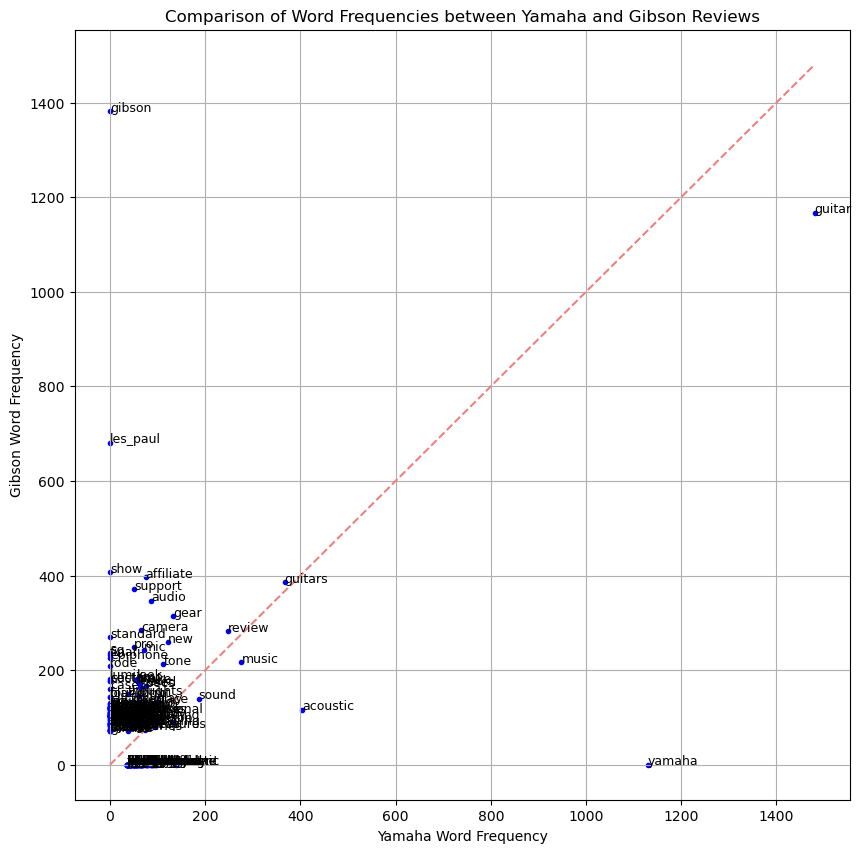

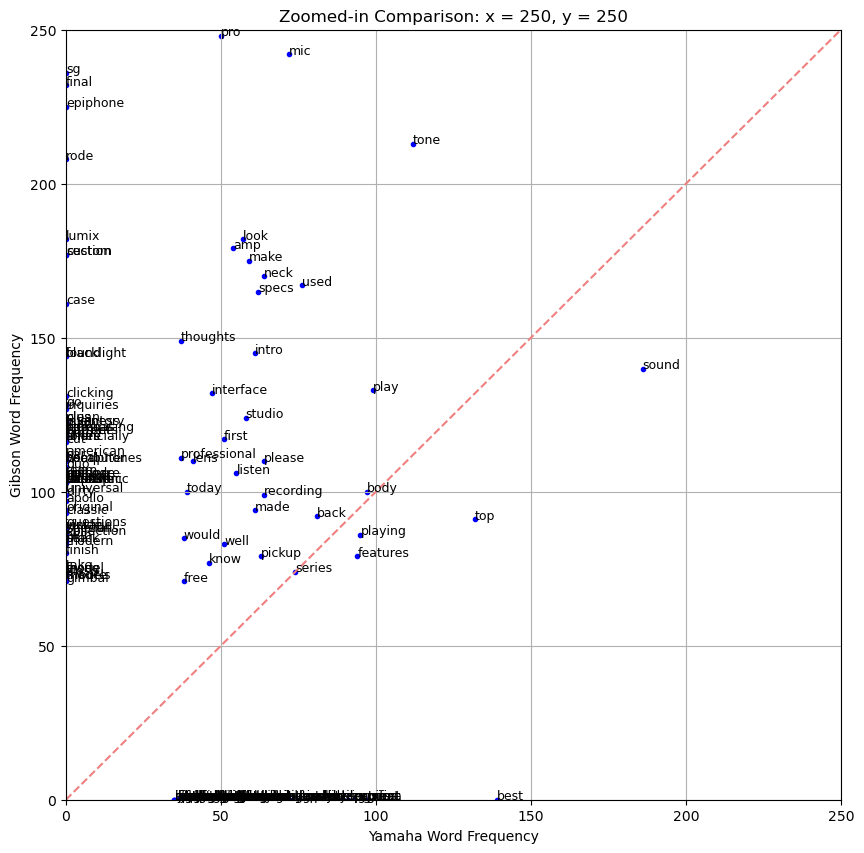

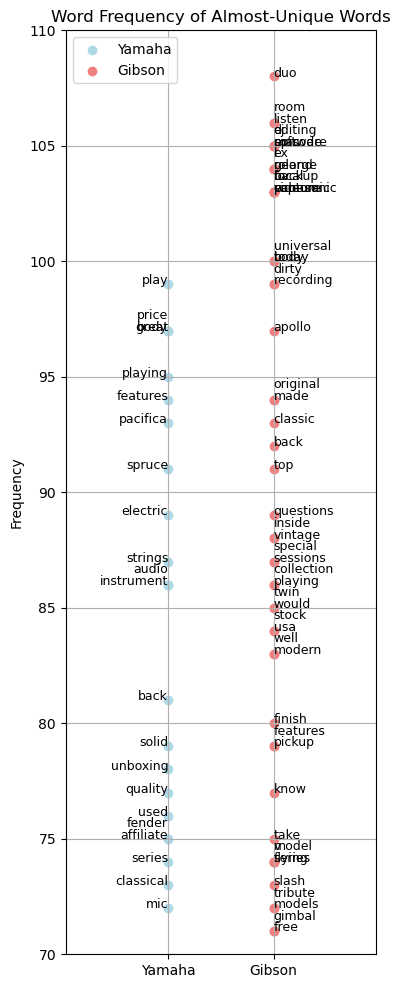

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import gensim.downloader as api
import nltk

# Manage workspaces with Git
current_directory = os.getcwd()
directory = ""
if current_directory[9:14] == 'vgwis':
    directory = "C:/Users/vgwis/Documents/Bana780/"
else:
    directory = "C:/Users/vgwcto/Documents/Python/Bana780/"

# Store API key locally
api_key = pd.read_csv(directory + 'key.csv').columns[0]

# Build a Function to easily search new ideas
def multiple_page_search(api_key, query, max_results = 50, max_pages = 10, cache_file = None):
    
    # Check if cache exists
    if cache_file and os.path.exists(cache_file):
        return pd.read_csv(cache_file)

    # Initialize the YouTube API client, variables
    youtube = build('youtube', 'v3', developerKey = api_key)
    descriptions = []
    next_page_token = None
    page_count = 0

    # Construct the API request
    while page_count < max_pages:
        search = youtube.search().list(
            q = query,
            part = 'snippet',
            type = 'video',
            maxResults = max_results,
            pageToken = next_page_token
        )
        response = search.execute()

        # Collect video IDs from the response to retrieve full descriptions
        video_ids = [item['id']['videoId'] for item in response['items']]

        video_request = youtube.videos().list(
            part = 'snippet',
            id = ','.join(video_ids)
        )
        video_response = video_request.execute()

        for item in video_response['items']:
            desc = item['snippet']['description']
            descriptions.append(desc)

        # Increment the page count
        next_page_token = response.get('nextPageToken')
        page_count += 1

    # Create a DataFrame from the collected descriptions, save to cache file
    df = pd.DataFrame(descriptions, columns = ['Description'])

    if cache_file:
        df.to_csv(cache_file, index = False)

    return df

A_df = multiple_page_search(api_key, 'Yamaha Guitar Review', cache_file = directory + 'A_cache.csv')
B_df = multiple_page_search(api_key, 'Gibson Guitar Review', cache_file = directory + 'B_cache.csv')

df = pd.DataFrame({
    'Yamaha': A_df['Description'],
    'Gibson': B_df['Description']
})

def remove_words_containing(input, remove_list):
    input = str(input)
    for remove in remove_list:
        pattern = re.compile(r'\b\S*' + re.escape(remove) + r'\S*\b', re.IGNORECASE)
        input = pattern.sub('', input)
    filtered_text = re.sub(r'\s+', ' ', input).strip()
    return filtered_text

remove_list = ['http', 'www', 'url', '.com', '.net', '.org', '.ca', '.de', '.io', '.me', 'Subscribe', 'Follow', 'Content', 'Notification', 'Amazon', 'TikTok', 'Instagram', 'Facebook', 'Twitter', 'LinkedIn', 'Snapchat', 'Pinterest', 'Reddit', 'Tumblr', 'YouTube', 'Vimeo', 'Google', 'Paypal', 'Ebay', 'bit.ly', 'youtu.be', 'linktr.ee', 'tidd.ly', 'goo.gl', 'amzn', 'ebay', 'website', 'shop', 'store', 'buy', 'sweetwater', 'guitar-center', 'amazon', 'reverb', 'keywords', 'search', 'link', 'merch'] 

for columm in df.columns:
    df[columm] = df[columm].apply(lambda x: remove_words_containing(x, remove_list = remove_list))

yamaha = " ".join(df['Yamaha'])
gibson = " ".join(df['Gibson'])

stop_words = set(nltk.corpus.stopwords.words('english'))
stop_words.update(['can', 'at', 'from', 'for', 'us', 'buy', 'shop', 'get', 'like', 'check', 'links', 'link', 'demo', 'amazon', 'ebay', 'find', 'one', 'two', 'three', 'video', 'videos', 'website', 'use', 'also', 'channel', 'description', 'help', 'subscribe', 'follow', 'content', 'notification', 'social', 'media', 'platform', 'comment', 'comments', 'email', 'patreon', 'reverb', 'x', 'sweetwater', 'give', 'let', 'vs'])

#Tokenize Yamaha
y_words = nltk.word_tokenize(yamaha)
y_words = [word.lower() for word in y_words if word.isalpha()]
y_words = [word for word in y_words if word.lower() not in stop_words]
y_wordfreqs = nltk.probability.FreqDist(w.lower() for w in y_words if w not in stop_words)
y_mostcommon = y_wordfreqs.most_common(125)
y_sents = nltk.sent_tokenize(yamaha)

#Tokenize Gibson
g_words = nltk.word_tokenize(gibson)
g_words = [word.lower() for word in g_words if word.isalpha()]
g_words = [word for word in g_words if word.lower() not in stop_words]
g_words = [item.replace('les', 'les_paul') for item in g_words]
g_words = [x for x in g_words if x != 'paul']
g_wordfreqs = nltk.probability.FreqDist(w.lower() for w in g_words if w not in stop_words)
g_mostcommon = g_wordfreqs.most_common(125)
g_sents = nltk.sent_tokenize(gibson)

# Create DataFrames from the most common words then merge on word
y_df = pd.DataFrame(y_mostcommon, columns=['word', 'yamaha_count'])
g_df = pd.DataFrame(g_mostcommon, columns=['word', 'gibson_count'])
merged_df = pd.merge(y_df, g_df, on='word', how='outer').fillna(0)

# Plot the scatterplot
plt.figure(figsize=(10, 10))
plt.scatter(merged_df['yamaha_count'], merged_df['gibson_count'], color='blue', marker='.')
plt.xlabel('Yamaha Word Frequency')
plt.ylabel('Gibson Word Frequency')
plt.title('Comparison of Word Frequencies between Yamaha and Gibson Reviews')
for i in range(len(merged_df)):
    plt.text(merged_df['yamaha_count'][i], merged_df['gibson_count'][i], merged_df['word'][i], fontsize=9)

# Add diagonal line where x = y
plt.plot([0, max(merged_df['yamaha_count'].max(), merged_df['gibson_count'].max())], 
         [0, max(merged_df['yamaha_count'].max(), merged_df['gibson_count'].max())], 
         color='lightcoral', linestyle='--')

plt.grid(True)
plt.show()

# New Zoomed in Graph
plt.figure(figsize=(10, 10))
plt.xlim(0, 250)
plt.ylim(0, 250)
plt.xlabel('Yamaha Word Frequency')
plt.ylabel('Gibson Word Frequency')
plt.title('Zoomed-in Comparison: x = 250, y = 250')
for i in range(len(merged_df)):
    if merged_df['yamaha_count'][i] <= 250 and merged_df['gibson_count'][i] <= 250:
        plt.scatter(merged_df['yamaha_count'][i], merged_df['gibson_count'][i], color='blue', marker='.')
        plt.text(merged_df['yamaha_count'][i], merged_df['gibson_count'][i], merged_df['word'][i], fontsize=9)

# Add diagonal line where x = y
plt.plot([0, max(merged_df['yamaha_count'].max(), merged_df['gibson_count'].max())], 
         [0, max(merged_df['yamaha_count'].max(), merged_df['gibson_count'].max())], 
         color='lightcoral', linestyle='--')

plt.grid(True)
plt.show()

# New Graph for unique words
y_df_filtered = y_df[(y_df['yamaha_count'] < 110) & (y_df['yamaha_count'] >= 70)].reset_index(drop=True)
g_df_filtered = g_df[(g_df['gibson_count'] < 110) & (g_df['gibson_count'] >= 70)].reset_index(drop=True)
plt.figure(figsize=(4, 12))
plt.scatter([0.33] * len(y_df_filtered), y_df_filtered['yamaha_count'], color='lightblue', label='Yamaha')
plt.scatter([0.67] * len(g_df_filtered), g_df_filtered['gibson_count'], color='lightcoral', label='Gibson')

# Adjust word labels to help avoid overlap
y_positions = y_df_filtered['yamaha_count'].tolist()
adjusted_y_positions = y_positions.copy()
for i in range(1, len(adjusted_y_positions)):
    if adjusted_y_positions[i] == adjusted_y_positions[i - 1]:
        adjusted_y_positions[i] += 0.5
g_positions = g_df_filtered['gibson_count'].tolist()
adjusted_g_positions = g_positions.copy()
for i in range(1, len(adjusted_g_positions)):
    if adjusted_g_positions[i] == adjusted_g_positions[i - 1]:
        adjusted_g_positions[i] += .5

for i in range(len(y_df_filtered)):
    plt.text(0.33, adjusted_y_positions[i], y_df_filtered['word'][i], fontsize=9, ha='right')
for i in range(len(g_df_filtered)):
    plt.text(0.67, adjusted_g_positions[i], g_df_filtered['word'][i], fontsize=9, ha='left')

plt.xlabel('')
plt.ylabel('Frequency')
plt.title('Word Frequency of Almost-Unique Words')
plt.xlim(0, 1)
plt.ylim(70, 110)
plt.xticks([0.33, 0.67], ['Yamaha', 'Gibson'])

plt.legend()
plt.grid(True)
plt.show()

# Using NLTK

First, I used NLTK to breakdown words on an individual level. After cleaning the description text, NLTK allowed me to plot words by frequency. On the first two plots above, the X and Y axes each represent a brand. The dashed line indicates the formula y = x, meaning words along this line appeared with equal frequency in both description corpus's.

Some of these results make clear sense. Epiphone is an imprint of Gibson and appears to be heavily correlated with Gibson alone. There are also many universal words close to the dotted line. However, it ultimately appears that Gibson reviews contain more "brainding" and "marketing" words to help sell their instruments (I did not attempt to limit sponsored reviews in my research.)

Next, I will attempt to chart a TSNE graph to understand related words.

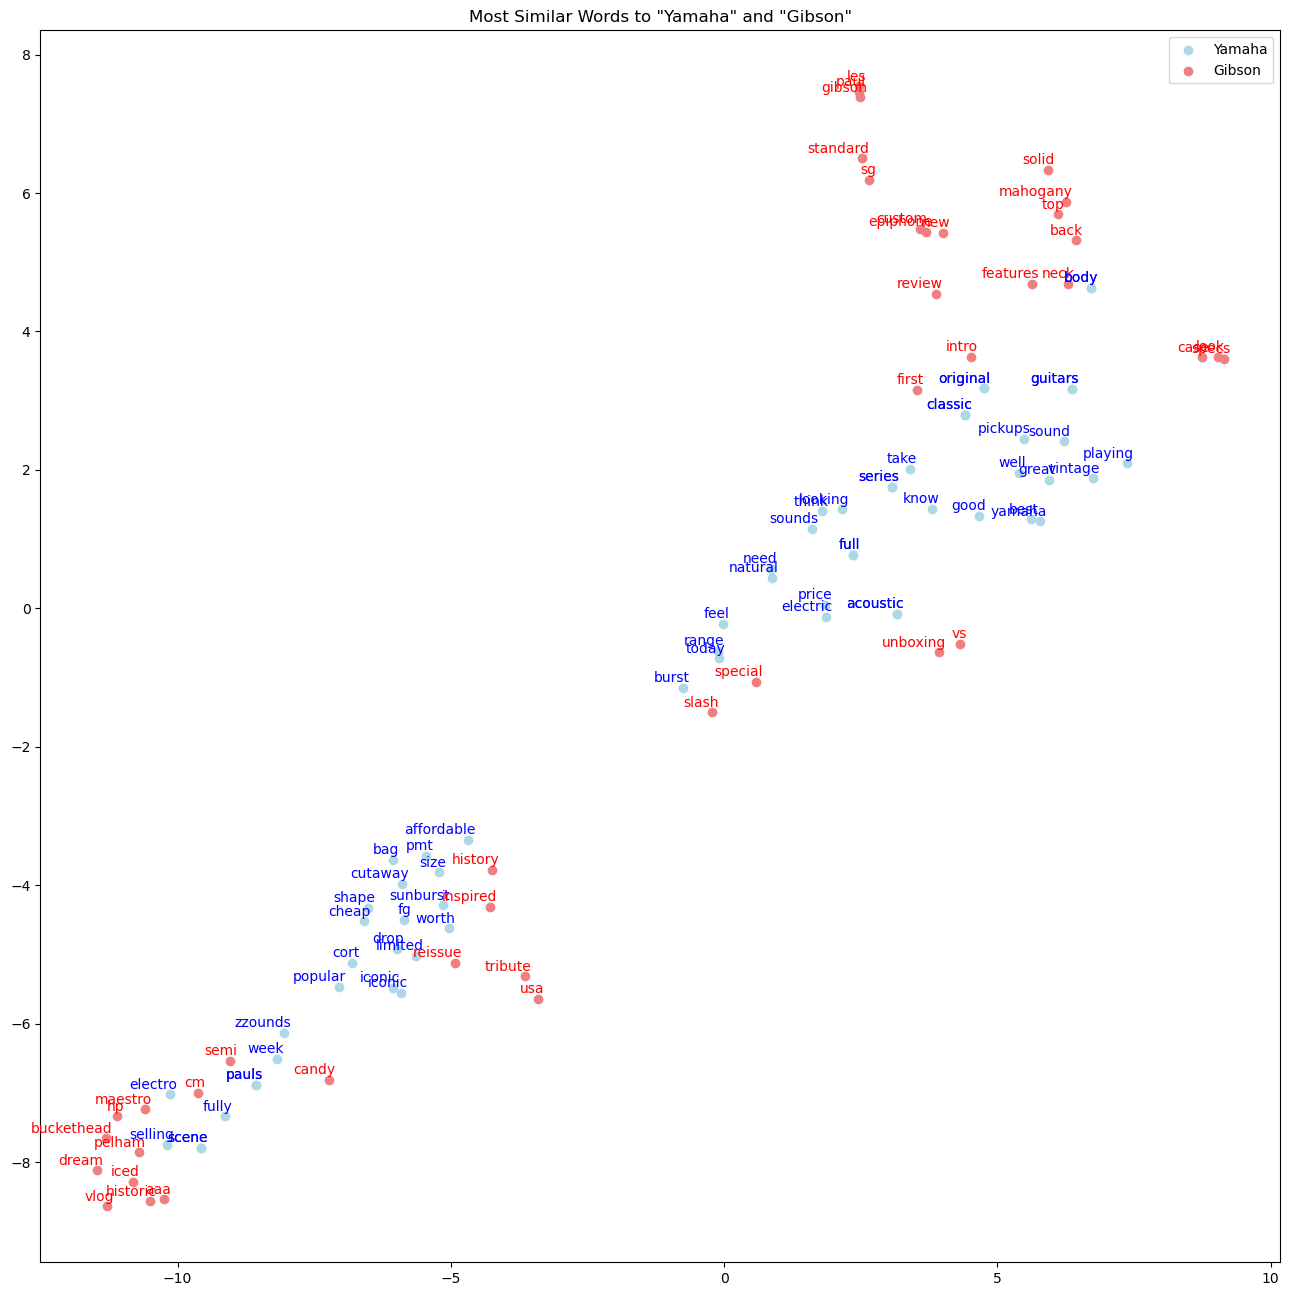

In [20]:
from gensim.models.word2vec import Word2Vec
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
import re
import nltk

# Load stop words
stop_words = set(nltk.corpus.stopwords.words('english'))
stop_words.update(['us', 'buy', 'shop', 'get', 'like', 'check', 'links', 'link', 'demo', 'amazon', 'ebay', 'find', 'one', 'two', 'three', 'video', 'videos', 'website', 'use', 'also', 'channel', 'description', 'help', 'subscribe', 'follow', 'content', 'notification', 'social', 'media', 'platform', 'comment', 'comments', 'email', 'patreon', 'reverb', 'x', 'sweetwater', 'give', 'let'])

# Function to preprocess text
def preprocess_text(text):
    text = re.sub(r'\b\S*http\S*\b', '', text)
    text = re.sub(r'\b\S*www\S*\b', '', text)
    text = re.sub(r'\b\S*com\S*\b', '', text)
    text = re.sub(r'\b\S*net\S*\b', '', text)
    text = re.sub(r'\b\S*org\S*\b', '', text)
    text = re.sub(r'\b\S*ca\S*\b', '', text)
    text = re.sub(r'\b\S*de\S*\b', '', text)
    text = re.sub(r'\b\S*io\S*\b', '', text)
    text = re.sub(r'\b\S*me\S*\b', '', text)
    text = re.sub(r'\b\S*Subscribe\S*\b', '', text)
    text = re.sub(r'\b\S*Follow\S*\b', '', text)
    text = re.sub(r'\b\S*Content\S*\b', '', text)
    text = re.sub(r'\b\S*Notification\S*\b', '', text)
    text = re.sub(r'\b\S*Amazon\S*\b', '', text)
    text = re.sub(r'\b\S*TikTok\S*\b', '', text)
    text = re.sub(r'\b\S*Instagram\S*\b', '', text)
    text = re.sub(r'\b\S*Facebook\S*\b', '', text)
    text = re.sub(r'\b\S*Twitter\S*\b', '', text)
    text = re.sub(r'\b\S*LinkedIn\S*\b', '', text)
    text = re.sub(r'\b\S*Snapchat\S*\b', '', text)
    text = re.sub(r'\b\S*Pinterest\S*\b', '', text)
    text = re.sub(r'\b\S*Reddit\S*\b', '', text)
    text = re.sub(r'\b\S*Tumblr\S*\b', '', text)
    text = re.sub(r'\b\S*YouTube\S*\b', '', text)
    text = re.sub(r'\b\S*Vimeo\S*\b', '', text)
    text = re.sub(r'\b\S*Google\S*\b', '', text)
    text = re.sub(r'\b\S*Paypal\S*\b', '', text)
    text = re.sub(r'\b\S*Ebay\S*\b', '', text)
    text = re.sub(r'\b\S*bit.ly\S*\b', '', text)
    text = re.sub(r'\b\S*youtu.be\S*\b', '', text)
    text = re.sub(r'\b\S*linktr.ee\S*\b', '', text)
    text = re.sub(r'\b\S*tidd.ly\S*\b', '', text)
    text = re.sub(r'\b\S*goo.gl\S*\b', '', text)
    text = re.sub(r'\b\S*amzn\S*\b', '', text)
    text = re.sub(r'\b\S*ebay\S*\b', '', text)
    text = re.sub(r'\b\S*website\S*\b', '', text)
    text = re.sub(r'\b\S*shop\S*\b', '', text)
    text = re.sub(r'\b\S*store\S*\b', '', text)
    text = re.sub(r'\b\S*buy\S*\b', '', text)
    text = re.sub(r'\b\S*sweetwater\S*\b', '', text)
    text = re.sub(r'\b\S*guitar-center\S*\b', '', text)
    text = re.sub(r'\b\S*amazon\S*\b', '', text)
    text = re.sub(r'\b\S*reverb\S*\b', '', text)
    text = re.sub(r'\b\S*keywords\S*\b', '', text)
    text = re.sub(r'\b\S*search\S*\b', '', text)
    text = re.sub(r'\b\S*link\S*\b', '', text)
    text = re.sub(r'\b\S*merch\S*\b', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Preprocess the text in the DataFrame
df['Yamaha'] = df['Yamaha'].apply(preprocess_text)
df['Gibson'] = df['Gibson'].apply(preprocess_text)

# Function to convert column to corpus
def columnToCorpus(column):
    column = column.apply(lambda x: ' '.join([word for word in x.split() if word.isalpha()]))
    column = column.apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))
    corpus = [z.lower().replace('\n','').split() for z in column]
    return corpus

y_train = columnToCorpus(df['Yamaha'])
g_train = columnToCorpus(df['Gibson'])

# Combine the Yamaha and Gibson reviews into a single corpus
combined_corpus = y_train + g_train

# Initialize and train a single Word2Vec model on the combined corpus
combined_w2v = Word2Vec(min_count=5)
combined_w2v.build_vocab(combined_corpus)
combined_w2v.train(combined_corpus, total_examples=combined_w2v.corpus_count, epochs=combined_w2v.epochs)

# Find the most similar words to "Yamaha" and "Gibson"
most_similar_yamaha = combined_w2v.wv.most_similar('yamaha', topn=50)
most_similar_gibson = combined_w2v.wv.most_similar('gibson', topn=50)

# Extract words and their vectors
words = ['yamaha', 'gibson']
words += [word for word, _ in most_similar_yamaha]
words += [word for word, _ in most_similar_gibson]

word_vectors = combined_w2v.wv[words]

# Create TSNE plot
tsne_model = TSNE(perplexity=25, n_components=2, init='pca', max_iter=2500, random_state=None)
new_values = tsne_model.fit_transform(word_vectors)

x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(16, 16))
for i in range(len(x)):
    if words[i] in ['yamaha'] + [word for word, _ in most_similar_yamaha]:
        plt.scatter(x[i], y[i], color='lightblue')
        plt.annotate(words[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom',
                     color='blue')
    else:
        plt.scatter(x[i], y[i], color='lightcoral')
        plt.annotate(words[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom',
                     color='red')

plt.title('Most Similar Words to "Yamaha" and "Gibson"')
plt.legend(['Yamaha', 'Gibson'])
plt.show()

# Using Word2Vec

In the TSNE plot above, I merged all reviews and used it as a corpus for training a Word2Vec model. I plotted words that were similar to Gibson and Yamaha in the same space. This corroborates some of the insights from previous graphs. Gibson is correlated with words like "History", "Inspired", "Reissue", and "Tribute", which signals that Gibson is trying to associate its brand with longevity. It also ropes in the word "Dream", suggesting the coveted status of Gibson guitars.

Meanwhile, Yamaha was connected to words like "Acoustic", "Electric", "Affordable", "Worth", and "Popular". This suggests a more utilitarian sentiment about Yamaha. It is also literally more correlated to the words "Good" and "Great"!

Perhaps the most important insight from this analysis is that Gibson is correlated with "Looks", while Yamaha is correlated with "Sounds". This is probably a great tell for anyone looking for a quality instrument, but I'll leave it up to the audience to put two and two together.

Ultimately, this analysis produced a lot of good qualitative data. I had a lot of a priori knowledge of each brand before this report, and I am partial to one of them. Yamaha, while not being known as a "brand" name like Nike or Rolex, has a good reputation for its price point. They make reliable instruments that have been favorites of esteemed classical, jazz, and pop musicians. Gibson, while not bad to own, is a brand known for its expensive premiums and association with rock 'n' roll lore. Comparing my expectations to the results from this report has been an interesting exercise in both data analysis and perception.